# Time Series Analysis (TSA) in Python - Linear Models to GARCH

http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#ARIMA

In [1]:
from utils.calvin_styles import *

In [4]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


In [5]:
# Let's use the pandas_datareader package to grab some sample data using the Yahoo Finance API
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

# Stationarity

* A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.
* Most of the models we use in TSA assume covariance-stationarity (#3 above). This means the descriptive statistics these models predict e.g. means, variances, and correlations, are only reliable if the TS is stationary and invalid otherwise.

"For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables." - http://people.duke.edu/~rnau/411diff.htm


![](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)



> With that said, most TS we encounter in finance is NOT stationary. Therefore a large part of TSA involves identifying if the series we want to predict is stationary, and if it is not we must find ways to transform it such that it is stationary.

# White Noise and Random Walks

White noise is the first Time Series Model (TSM) we need to understand. By definition a time series that is a white noise process has serially UNcorrelated errors and the expected mean of those errors is equal to zero. Another description for serially uncorrelated errors is, independent and identically distributed (i.i.d.). This is important because, if our TSM is appropriate and successful at capturing the underlying process, the residuals of our model will be i.i.d. and resemble a white noise process. Therefore part of TSA is literally trying to fit a model to the time series such that the residual series is indistinguishable from white noise.

In [9]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

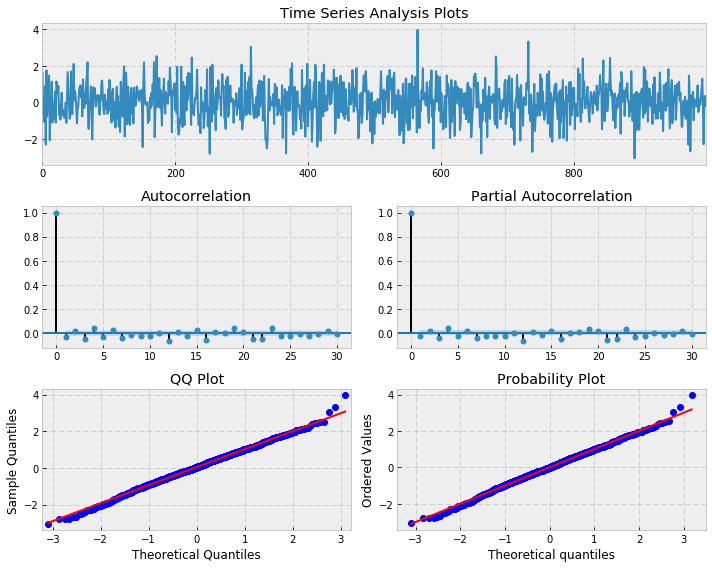

In [10]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [7]:
lrets

,MSFT,SPY,TLT
Date,,,
2007-01-04,-0.001676,0.002120,0.006045
2007-01-05,-0.005719,-0.008008,-0.004362
2007-01-08,0.009737,0.004614,0.001792
2007-01-09,0.001002,-0.000850,0.000000
2007-01-10,-0.010064,0.003326,-0.004486
2007-01-11,0.034463,0.004371,-0.005862
2007-01-12,0.016476,0.007568,-0.004646
2007-01-16,-0.001603,-0.001957,0.002156
2007-01-17,-0.001927,0.000420,-0.003065
